# Color Discretization

### ColorDiscretizer demo

In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
from utils.color_discretizer import ColorDiscretizer
from utils.color_utils import YUV_to_RGB, RGB_to_YUV
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical

/Users/marc/.miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
cd = ColorDiscretizer()
imdir = "../data/iccv09Data/images/"
cd.train(imdir, 30)

/Users/marc/Documents/Dropbox/Stanford/Class/3rdQuarter/CS231N/project/all-colors-matter/utils/color_discretizer.py:62: RuntimeWarning: divide by zero encountered in log10
  logheatmap = np.log10(hm)


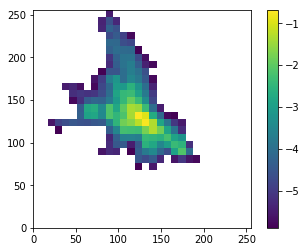

In [4]:
cd.plot_heatmap()

In [5]:
from scipy.ndimage import imread
from utils.color_utils import RGB_to_YUV

image = imread("../data/iccv09Data/images/0002136.jpg").astype(np.dtype("float32"))
YUVimage = RGB_to_YUV(image)
UVimage = YUVimage[:, :, 1:]
UVpixels = np.reshape(UVimage, newshape=[-1, 2])

/Users/marc/.miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


In [6]:
cd.categorize(UVimage)

array([[148, 148, 148, ..., 148, 148, 148],
       [148, 148, 148, ..., 148, 148, 148],
       [148, 148, 148, ..., 148, 148, 148],
       ...,
       [160, 160, 160, ..., 147, 147, 147],
       [160, 160, 160, ..., 131, 131, 131],
       [160, 160, 160, ..., 131, 131, 131]])

In [7]:
unique, counts = np.unique(cd.categorize(UVimage), return_counts=True)

In [8]:
unique

array([  0,  34,  35,  36,  47,  48,  49,  50,  51,  52,  53,  55,  56,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 173, 176])

In [9]:
counts

array([   77,     1,     3,    10,     1,     4,    37,    63,    42,
          33,     2,     3,     1,     3,    54,   106,   121,   128,
          60,    45,    35,     4,     1,    19,     1,    17,    61,
         101,   128,   152,   176,   123,   188,    69,     4,     1,
         126,    66,    76,   153,   146,   144,   203,   296,   206,
         162,   193,    35,     2,    21,   342,  2090,  1218,   718,
         528,   375,   301,   229,   198,   162,    79,    28,     3,
        1822,  8257, 10063,  1554,   846,   393,   246,   174,   147,
          49,    46,     6,     3,   243, 10594, 12673,  1543,   304,
         170,    91,    34,    17,     7,     1,    26,  3000, 11566,
        2114,    89,    59,    33,     2,   315,   297,     6,    27,
           3,     1,     1,     4])

In [22]:
categories_distributions = np.abs(np.random.rand(4, 4, cd.n_categories))
cd.UVpixels_from_distribution(categories_distributions)



array([[[112.521249  , 144.48923101],
        [110.71118492, 144.62923939],
        [111.83989432, 146.00019774],
        [111.87374006, 143.7835388 ]],

       [[112.03231813, 145.48358456],
        [110.63258432, 141.37331318],
        [110.43317059, 145.88069163],
        [111.97174618, 143.24908085]],

       [[111.08777974, 143.25656069],
        [112.77128319, 143.95430209],
        [111.16454215, 140.98293789],
        [111.39561618, 143.09439108]],

       [[109.40003368, 144.97062704],
        [107.77337416, 147.36072706],
        [110.91731583, 146.09356514],
        [109.9468971 , 144.1205663 ]]])

### L2 cost of categorizing

In [23]:
image = imread("../data/iccv09Data/images/0002136.jpg").astype(np.dtype("float32"))
YUVimage = RGB_to_YUV(image)
UVimage = YUVimage[:, :, 1:]
Yimage = YUVimage[:, :, :1]

/Users/marc/.miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  if __name__ == '__main__':


In [39]:
pixels_categories = cd.categorize(UVimage)

pixel_categories_onehot = to_categorical(pixels_categories, num_classes=cd.n_categories)

reconstructed_UVimage = cd.UVpixels_from_distribution(pixel_categories_onehot)

/Users/marc/Documents/Dropbox/Stanford/Class/3rdQuarter/CS231N/project/all-colors-matter/utils/color_discretizer.py:101: RuntimeWarning: divide by zero encountered in log
  temp_distribution = np.exp(np.log(distribution) / temperature)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


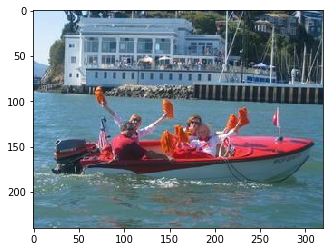

In [40]:
plt.imshow(YUV_to_RGB(np.concatenate([Yimage, UVimage], axis=2)) / 255)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


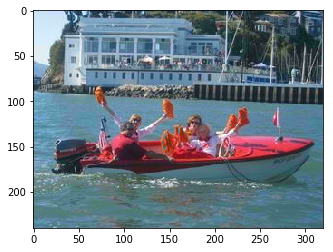

In [41]:
plt.imshow(YUV_to_RGB(np.concatenate([Yimage, reconstructed_UVimage], axis=2)) / 255)
plt.show()

In [42]:
np.linalg.norm(reconstructed_UVimage - UVimage, axis = (0, 1)) / len(UVpixels) / np.std(UVpixels, axis = 0)

array([0.00101695, 0.00058714])

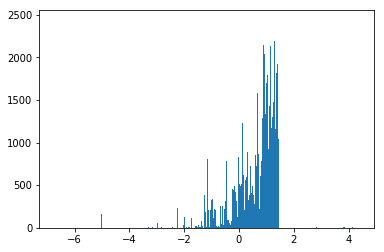

In [44]:
plt.hist(np.reshape(np.log(np.abs(reconstructed_UVimage - UVimage)), [-1, 1]), bins = 1000)
plt.show()

Note that sometimes, the return to RGB space goes over 255 or below 0. 

In [45]:
print(np.max(YUV_to_RGB(np.concatenate([Yimage, UVimage], axis=2))))
print(np.min(YUV_to_RGB(np.concatenate([Yimage, UVimage], axis=2))))

255.000001162996
-2.3071272039487667e-06


In [46]:
print(np.max(YUV_to_RGB(np.concatenate([Yimage, reconstructed_UVimage], axis=2))))
print(np.min(YUV_to_RGB(np.concatenate([Yimage, reconstructed_UVimage], axis=2))))

262.475958305796
-6.780124214119951


### Thresholding out rare pixels

/Users/marc/Documents/Dropbox/Stanford/Class/3rdQuarter/CS231N/project/all-colors-matter/utils/color_discretizer.py:62: RuntimeWarning: divide by zero encountered in log10
  logheatmap = np.log10(hm)


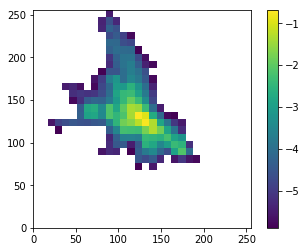

Remaining colors: 187


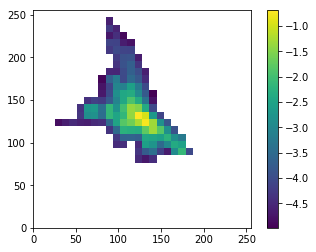

Remaining colors: 139


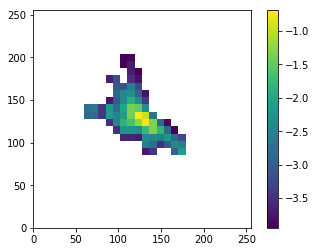

Remaining colors: 81


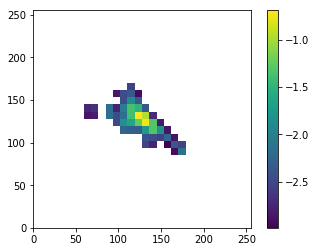

Remaining colors: 51


In [19]:
for threshold in [.000001, .00001, .0001, .001]:
    cd = ColorDiscretizer(threshold=threshold)
    imdir = "../data/iccv09Data/images/"
    cd.train(imdir, 30)
    cd.plot_heatmap()
    print("Remaining colors: {}".format(np.sum(cd.heatmap > cd.threshold)))